## Imports

In [81]:
import os
import sys
import glob
import logging

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    Transform,
    Resize,
    CenterSpatialCrop,
    AdjustContrast
)

from monai.data import CacheDataset, DataLoader
from monai.visualize import matshow3d
from monai.utils import first, set_determinism
from monai.apps import get_logger

## Determinism, device and logger

In [45]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA TITAN RTX


In [46]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
get_logger('train_log')
set_determinism(0)
device = torch.device('cuda:0')

In [47]:
torch.cuda.empty_cache()
torch.cuda.memory_stats()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

## Load and prepare dataset

In [76]:
image_size = 256
num_slices = 128
contrast_gamma = 1.5
every_n_slice = 8
batch_size = 1

learning_rate = 1e-4
channels = 1
num_epochs = 100
latent_size = 64
critic_features = 16
generator_features = 16
critic_iterations = 5
lambda_gp = 10

In [49]:
data_dir = '/data1/dose-3d-generative/data_med/PREPARED/FOR_AUG'
directory = os.path.join(data_dir, 'ct_images')
images_pattern = os.path.join(directory, '*.nii.gz')
images = sorted(glob.glob(images_pattern))[:3]

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        CenterSpatialCrop((400, 400, 0)),
        Resize((image_size, image_size, num_slices)),
        ScaleIntensity(),
        AdjustContrast(contrast_gamma),
        RandRotate(range_x=np.pi/12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType()
    ]
)

dataset = CacheDataset(images, train_transforms)
loader = torch.utils.data.DataLoader(dataset, num_workers=10, shuffle=True, pin_memory=torch.cuda.is_available())

Loading dataset: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


(1, 1, 256, 256, 128)


(<Figure size 1000x1000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

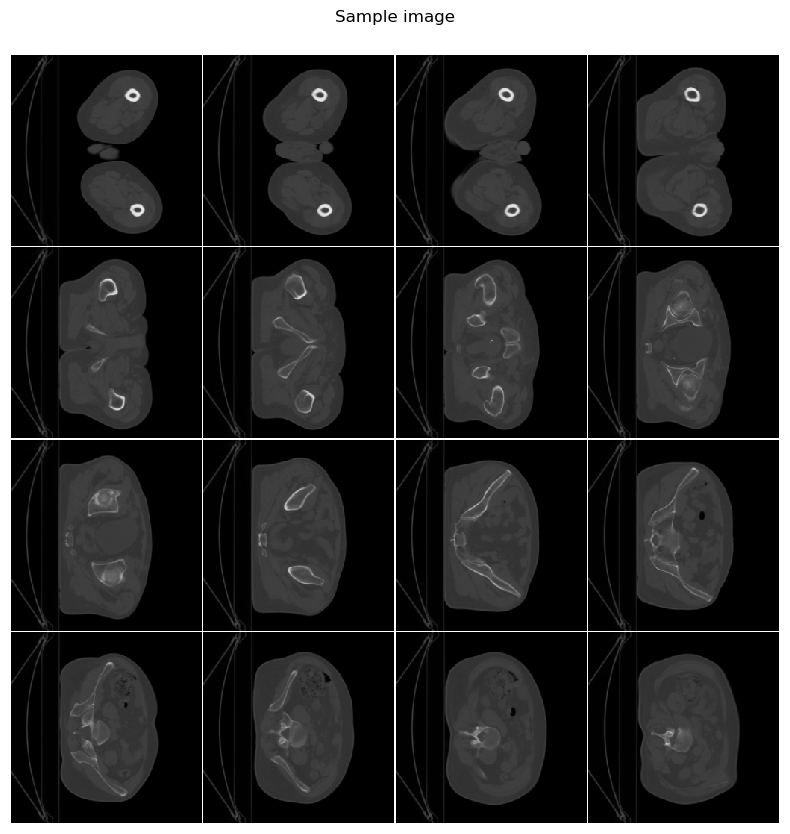

In [50]:
image_sample = first(loader)
print(image_sample.shape)

fig = plt.figure(figsize=(15,15))
matshow3d(volume=image_sample,
          fig=fig,
          title="Sample image",
          every_n=every_n_slice,
          frame_dim=-1,
          cmap="gray")

## Define model architecture

In [79]:
class Critic(nn.Module):
    def __init__(self, channels, features):
        super(Critic, self).__init__()

        self.net = nn.Sequential(
            nn.Conv3d(channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features, 2*features, 4, 2, 1),
            self._block(2*features, 4*features, 4, 2, 1),
            self._block(4*features, 8*features, 4, 2, 1),
            self._block(8*features, 16*features, 4, 2, 1),
            nn.Conv3d(16*features, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.net(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels, features):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            self._block(channels_noise, 16*features, 4, 1, 0),
            self._block(16*features, 8*features, 4, 2, 1),
            self._block(8*features, 4*features, 4, 2, 1),
            self._block(4*features, 2*features, 4, 2, 1),
            self._block(2*features, features, 4, 2, 1),
            nn.ConvTranspose3d(features, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d, nn.BatchNorm3d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty(critic, real, fake, device='cpu'):
    batch_size, c, h, w, d = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1, 1)).repeat(1, c, h, w, d).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

def test():
    N, in_channels, H, W, D = 1, 1, 128, 128, 128
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W, D))
    disc = Critic(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W, D), "Generator test failed"
    print("Success, tests passed!")

    test()

## Initialize and train model

In [84]:
# create and initialize networks

critic = Critic(channels, critic_features).to(device)
initialize_weights(critic)

generator = Generator(latent_size, channels, generator_features).to(device)
initialize_weights(generator)

In [85]:
# initialize optimizers

opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.0, 0.9))
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))

In [87]:
noise = torch.randn(1, latent_size, 1, 1, 1).to(device)
step = 0

critic.train()
generator.train()

for epoch in range(num_epochs):
    pass